In [1]:
#Importing modules
import Quandl
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import seaborn as sns
sns.set(color_codes=True, font_scale = 1.5, style = 'darkgrid')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn import svm, preprocessing, cross_validation, linear_model, ensemble

C:\Users\ArchishmanMitra\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


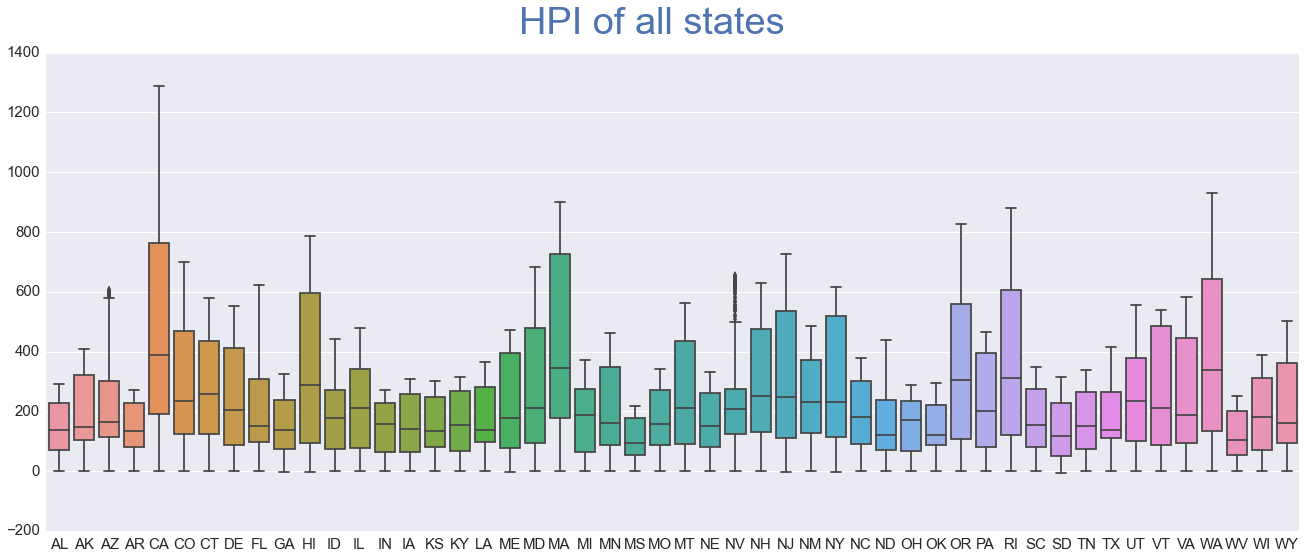

In [2]:
#Using my authorization token for Quandl
auth_token = open("auth_key.txt",'r').read()

#Creating a List of abbreviation of each state
# def list_states():
#     df = pd.read_html("http://www.50states.com/abbreviations.htm#.VnM8VfkrLIU")
#     df_states = pd.DataFrame(df[0])
#     df_states = df_states.iloc[1:51][1]
#     #list_states = df_states["Abbreviation"]
#     list_states = np.array(df_states)
#     return list_states

# #Getting house prices of all states from Quandl by modifying its get function
# def house_price_all_states():
#     main_df = pd.DataFrame()
#     states = list_states()
#     for abbv in states:
#         df = Quandl.get("FMAC/HPI_"+str(abbv), authtoken = auth_token)
#         df[abbv] = ((df[abbv]-df[abbv][0])/df[abbv][0]) * 100
#         if main_df.empty:
#             main_df = df
#         else:
#             main_df = main_df.join(df)
#     main_df.to_pickle("fiddy_state.pickle") #Pickling the data to reduce run time
# house_price_all_states()

HPI_All_States = pd.read_pickle("fiddy_state.pickle")

#Plotting Boxplot of percent change of each state
plt.figure(figsize=(20,8))
sns.boxplot(data=HPI_All_States)
plt.suptitle("HPI of all states", x=0.5,y=0.98, color = 'b', size = 38)
plt.show()

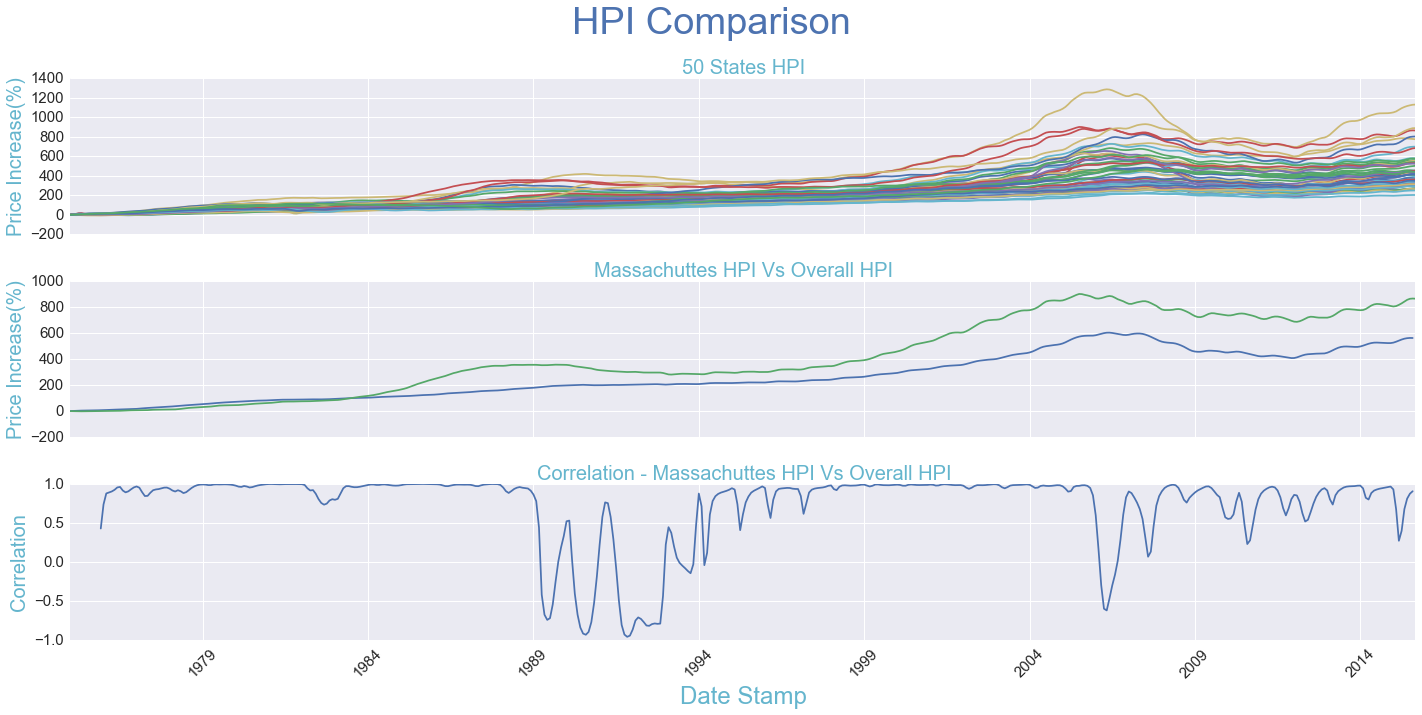

In [3]:
#Gathering US house price data
def benchmark():
    df = Quandl.get("FMAC/HPI_USA", authtoken = auth_token)
    df.columns = ["US_HPI"]
    #Scaling data points
    df["US_HPI"] = ((df["US_HPI"]-df["US_HPI"][0])/df["US_HPI"][0]) * 100
    return df

HPI_US = benchmark()
HPI_US["US_HPI_Future"] = HPI_US["US_HPI"].shift(-1)
HPI_US.dropna(inplace = True)
fig = plt.figure()
plt.figure(figsize=(20,10))

#Plotting all states HPI and correlation between MA and US HPI
plt.suptitle("HPI Comparison", x=0.5,y=0.98, color = 'b', size = 38)
ax1 =  plt.subplot2grid((3,1),(0,0))
HPI_All_States.plot(legend = False, fig = fig, ax = ax1)
ax1.set_title('50 States HPI', color = 'c', size = 20)
ax1.set_ylabel("Price Increase(%)", color = 'c', size = 20)

ax2 = plt.subplot2grid((3,1),(1,0), sharex = ax1)
HPI_US["US_HPI_Future"].plot(ax = ax2, label = 'Future HPI' )
HPI_All_States['MA'].plot(ax = ax2, label = 'MA HPI')
ax2.set_title('Massachuttes HPI Vs Overall HPI', color = 'c', size = 20)
ax2.set_ylabel("Price Increase(%)", color = 'c', size = 20)

ax3 = plt.subplot2grid((3,1),(2,0), sharex = ax1)
HPI_corr = pd.rolling_corr(HPI_All_States['MA'], HPI_US["US_HPI_Future"], 12)
HPI_corr.plot(ax = ax3, label = 'Correlation')
ax3.set_title('Correlation - Massachuttes HPI Vs Overall HPI', color = 'c', size = 20)
for label in ax3.xaxis.get_ticklabels():
        label.set_rotation(45)
ax3.set_xlabel("Date Stamp", color = 'c', size = 24)
ax3.set_ylabel("Correlation", color = 'c', size = 20)

plt.subplots_adjust(left=0.056, bottom=0.10, right=0.99, top=0.88, wspace=0.0, hspace=0.3)      
plt.show()

              AL         AK         AZ         AR         CA         CO  \
count  52.000000  52.000000  52.000000  52.000000  52.000000  52.000000   
mean    0.969750   0.936543   0.930286   0.971007   0.944899   0.957396   
std     0.027255   0.044276   0.030142   0.027912   0.028140   0.029905   
min     0.864963   0.758296   0.836533   0.852639   0.865150   0.833116   
25%     0.956560   0.928066   0.915171   0.966409   0.930089   0.944313   
50%     0.977251   0.945549   0.931981   0.979260   0.945350   0.963864   
75%     0.986670   0.960859   0.947713   0.988598   0.966184   0.976420   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              CT         DE         FL         GA      ...               TX  \
count  52.000000  52.000000  52.000000  52.000000      ...        52.000000   
mean    0.936883   0.964843   0.926705   0.950899      ...         0.938300   
std     0.037310   0.028847   0.034767   0.029939      ...         0.040739   
min     

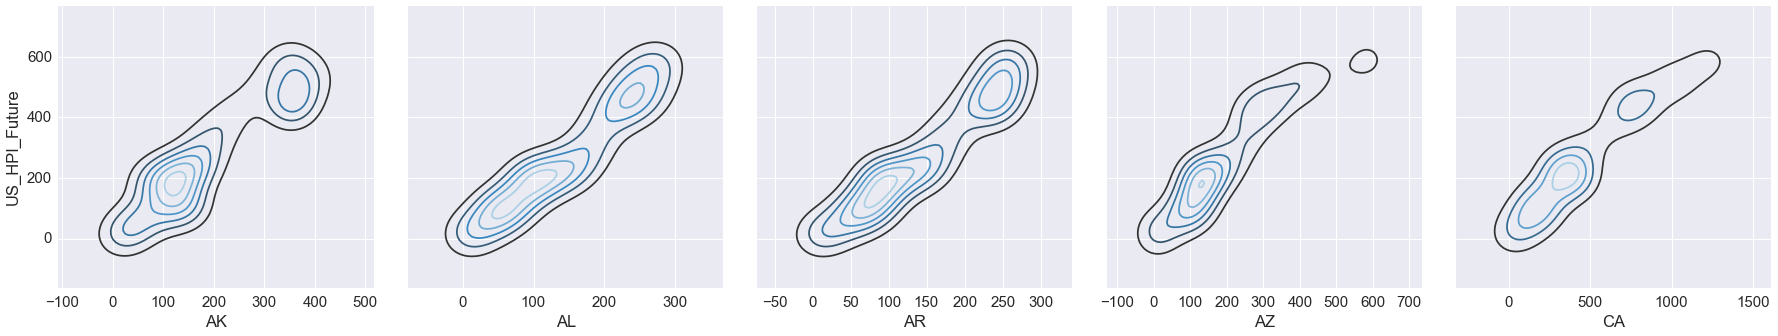

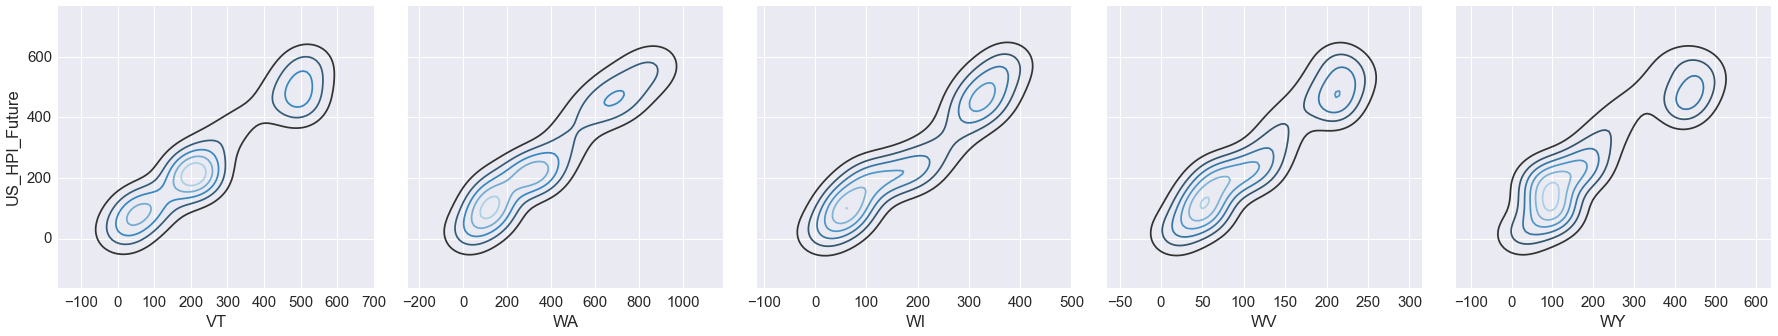

In [4]:
HPI_combined = HPI_All_States.join(HPI_US[['US_HPI', "US_HPI_Future"]])
HPI_combined.dropna(inplace = True)

HPI_corr = HPI_combined.corr()
print(HPI_corr.describe())
HPI_corr = HPI_corr.iloc[0:50][['US_HPI',"US_HPI_Future"]]

Least_corr_states = (HPI_corr.sort(inplace = False)).head(5)
Least_corr_states = list(Least_corr_states.index.values)
Highest_corr_states = (HPI_corr.sort(inplace = False)).tail(5)
Highest_corr_states = list(Highest_corr_states.index.values)

for num in range(np.int(len(Least_corr_states)/5)):
    g = sns.PairGrid(HPI_combined, x_vars= Least_corr_states[num:num+5], y_vars=["US_HPI_Future"], palette="Set2", size = 5)
    g.map(sns.kdeplot, cmap="Blues_d", n_levels=6)
for num in range(np.int(len(Highest_corr_states)/5)):
    g = sns.PairGrid(HPI_combined, x_vars= Highest_corr_states[num:num+5], y_vars=["US_HPI_Future"], palette="Set2", size = 5)
    g.map(sns.kdeplot, cmap="Blues_d", n_levels=6)
plt.show()

                 US_gdp  US_HPI_Future
US_gdp         1.000000       0.587365
US_HPI_Future  0.587365       1.000000


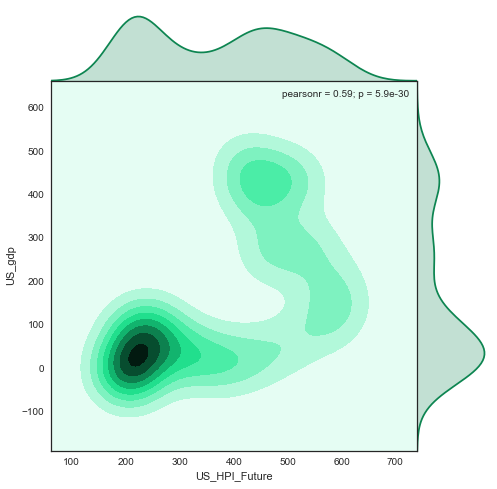

In [5]:
#Getting US GPD data
def gdp():
    df = Quandl.get("BCB/4385", authtoken=auth_token, trim_start="1974-12-31")
    df.columns = ["US_gdp"]
    #Scaling data points
    df["US_gdp"] = ((df["US_gdp"]-df["US_gdp"][0])/df["US_gdp"][0]) * 100
    return df

US_GDP = gdp()
HPI_combined = HPI_combined.join(US_GDP["US_gdp"])
HPI_combined.dropna(inplace = True)

print(HPI_combined[["US_gdp","US_HPI_Future"]].corr())

sns.set(style="white")
sns.jointplot(x=HPI_combined["US_HPI_Future"], y=HPI_combined["US_gdp"], kind = 'kde', color="#0d8551", space = 0, size = 7)

               Mortage_Rates  US_HPI_Future
Mortage_Rates       1.000000      -0.747675
US_HPI_Future      -0.747675       1.000000


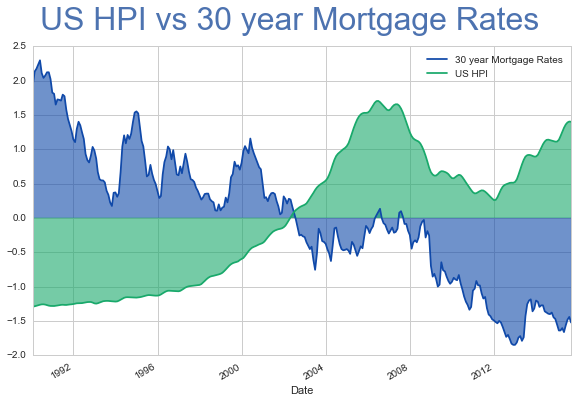

In [6]:
#Getting US Mortgage rates data
def mortgage_30():
    df = Quandl.get("FMAC/MORTG", authtoken = auth_token, trim_start = "1975-01-01")
    df.columns = ["Mortage_Rates"]
    #Scaling and adjusting data points
    df["Mortage_Rates"] = ((df["Mortage_Rates"]-df["Mortage_Rates"][0])/df["Mortage_Rates"][0]) * 100
    df = df.resample('D')
    df = df.resample('M')
    return df

#Combining and checking correlation 
Mortage_Rates = mortgage_30()
HPI_combined = HPI_combined.join(Mortage_Rates)
HPI_combined.dropna(inplace = True)
print(HPI_combined[["Mortage_Rates","US_HPI_Future"]].corr())

#Normalizing to faciliate plotting in same axes
HPI_combined_norm = (HPI_combined - HPI_combined.mean())/HPI_combined.std()

#Plotting US HPI vs 30 year Mortgage Rates
sns.set(style='whitegrid')
ax1 =  plt.subplot2grid((1,1),(0,0))
plt.suptitle("US HPI vs 30 year Mortgage Rates", x=0.5,y=0.98, color = 'b', size = 32)

ax1.plot(HPI_combined_norm.index, HPI_combined_norm.Mortage_Rates, label = '30 year Mortgage Rates',color = '#1049a9')
HPI_combined_norm['US_HPI_Future'].plot(ax = ax1, label = 'US HPI', color = '#19a96b')
#Adding a fill
ax1.fill_between(HPI_combined_norm.index, HPI_combined_norm.Mortage_Rates, alpha = 0.6, color = '#1049a9')
ax1.fill_between(HPI_combined_norm.index, HPI_combined_norm['US_HPI_Future'], alpha = 0.6, color = '#19a96b')

plt.subplots_adjust(left=0.056, bottom=0.10, right=0.99, top=0.88, wspace=0.0, hspace=0.0)      
plt.legend()
plt.show()

               Unemployment  US_HPI_Future
Unemployment       1.000000       0.022649
US_HPI_Future      0.022649       1.000000


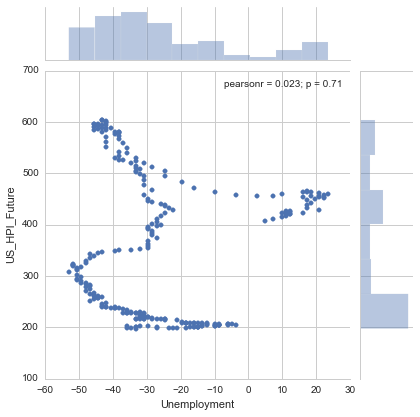

In [7]:
#Getting US Unemployment data
def unemployment():
    df = Quandl.get("ECPI/JOB_G", authtoken = auth_token, trim_start = "1975-01-01")
    df.columns = ["Unemployment"]
    #Scaling and adjusting data points
    df["Unemployment"] = ((df["Unemployment"]-df["Unemployment"][0])/df["Unemployment"][0]) * 100
    df = df.resample('D')
    df = df.resample('M')
    return df

#Combining and checking correlation 
Unemployment = unemployment()
HPI_combined = HPI_combined.join(Unemployment)
HPI_combined.dropna(inplace = True)
print(HPI_combined[["Unemployment","US_HPI_Future"]].corr())

#Figuring out some pattern by plotting scatter plot of Unemployment vs US HPI 
sns.jointplot(x='Unemployment', y = 'US_HPI_Future', data = HPI_combined)
plt.show()

#Very poor correlation, not using unemployment data
HPI_combined.drop('Unemployment', 1, inplace = True)

                  SP500  US_HPI_Future
SP500          1.000000       0.736759
US_HPI_Future  0.736759       1.000000


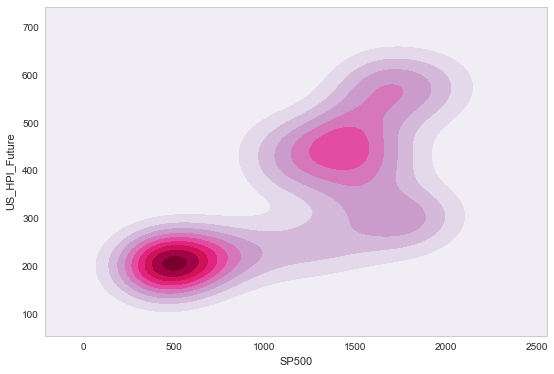

In [8]:
#S&P500
def sp500():
    df = Quandl.get("YAHOO/INDEX_GSPC", authtoken = auth_token, trim_start = "1975-01-01")
    df = pd.DataFrame(df["Close"]) #Using the close datapoints from the OHLC options
    df = df.resample('M')
    df.columns = ["SP500"]
    df["SP500"] = ((df["SP500"]-df["SP500"][0])/df["SP500"][0]) * 100
    return df

#Combining and checking correlation 
SP500 = sp500()
HPI_combined = HPI_combined.join(SP500)
HPI_combined.dropna(inplace = True)
print(HPI_combined[["SP500","US_HPI_Future"]].corr())

#Plotting density plot between US HPI and S&P500
sns.kdeplot(HPI_combined.SP500 , HPI_combined.US_HPI_Future, cmap = 'PuRd', shade = True)

HPI_combined.to_pickle('housing_market.pickle')

In [9]:
#Readying the data for classification
def label_fun(first, second):
    if second > first:
        label = 1
    else:
        label = 0
    return label

#Retrieving previously pickled data
housing_market = pd.read_pickle("housing_market.pickle")

#Changing data resolution to help classification algorithm
housing_market = housing_market.pct_change()
housing_market.replace([np.inf, -np.inf], np.nan, inplace = True)
housing_market.dropna(inplace = True)
#Labeling using increase or decrease from previous month
housing_market["label"] = list(map(label_fun, housing_market["US_HPI"],housing_market["US_HPI_Future"]))

#Creating feature dataframe and Output dataframe
X = np.array(housing_market.drop(["US_HPI_Future","label"], 1 ))
X = preprocessing.scale(X)
y = np.array(housing_market["label"])

#Dividing the data into test and training sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.4)

In [11]:
# Logistic Regression

logreg = linear_model.LogisticRegression()

logreg.fit(X_train, y_train)

print('Accuracy '+str(logreg.score(X_test, y_test)))

#Building the coefficient/weights table
df_wghts = housing_market.drop(["US_HPI_Future","label"], 1)
df_wghts = pd.DataFrame(df_wghts.columns)
df_wghts.columns = ["Features"]
df_wghts["Coefficient Estimate"] = pd.Series(logreg.coef_[0])
df_wghts

Accuracy 0.714285714286


,Features,Coefficient Estimate
0,AL,-0.019610
1,AK,-0.324527
2,AZ,-0.528110
3,AR,-0.130663
4,CA,0.637785
5,CO,1.024910
6,CT,0.183256
7,DE,-0.730347
8,FL,-0.120320
9,GA,0.814184
